In [35]:
import warnings
import matplotlib
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [36]:
import sys
sys.path.insert(0, '/home/user/Projects/Matterport3DSimulatorDocker/build_py385')
print(sys.path)
from tasks.R2R.env import R2RBatch
env = R2RBatch(None, connectivity_dir='./datasets/R2R/connectivity', batch_size=64, splits=['./datasets/R2R/annotations/R2R_train_enc.json',
                                            './datasets/R2R/annotations/R2R_val_seen_enc.json',
                                            './datasets/R2R/annotations/R2R_val_unseen_enc.json'])

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import json
import random

from plot_utils import plot_each, plot_gif
from tasks.R2R.eval import Evaluation
e = Evaluation(['./datasets/R2R/annotations/R2R_train_enc.json',
                                            './datasets/R2R/annotations/R2R_val_seen_enc.json',
                                            './datasets/R2R/annotations/R2R_val_unseen_enc.json'], connectivity_dir='./datasets/R2R/connectivity')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
def grab_traj(outfile):
    with open(outfile) as f:
        epis = e.inspect_results(json.load(f))

    return epis

def grab_kidnap_locs(outfile):
    epis = {}
    with open(outfile) as f:
        for epi in f:
            epi_ = json.loads(epi)
            epis[f"{epi_['instr_id']}/{epi_['env']}"] = epi_ 
    return epis

def get_ground_truth(instr_id):
    gt = e.gt[int(instr_id.split('_')[0])]
    item = {'instr_id': instr_id, 'path': gt['path']}
    return item

In [39]:
########### INPUT THE DESIRED TRAJECTORIES HERE
#outfolder = ''
#print(os.listdir(outfolder))

def get_eval_trajs(model, task, print_stats=False):
    test_val_seen = f'/home/user/Projects/{model}/test/{task}/preds/detail_val_seen.json'
    test_val_unseen = f'/home/user/Projects/{model}/test/{task}/preds/detail_val_unseen.json'
    baseline_val_seen = f'/home/user/Projects/{model}/test/baseline/preds/detail_val_seen.json'
    baseline_val_unseen = f'/home/user/Projects/{model}/test/baseline/preds/detail_val_unseen.json'
    test_val_locs = grab_kidnap_locs(f"/home/user/Projects/{model}/test/{task}/logs/kidnap_log.jsonl")

    kidnapped_test_val_seen_traj = {v['instr_id'].split('/')[0]: v  for k, v in test_val_locs.items() if v['env'] == 'val_seen' and v['is_kidnapped']}
    kidnapped_test_val_unseen_traj = { v['instr_id'].split('/')[0]: v  for k, v in test_val_locs.items() if v['env'] == 'val_unseen' and v['is_kidnapped'] }

    kidnapped_test_val_seen = set([t['instr_id'] for t in kidnapped_test_val_seen_traj.values() if t['is_kidnapped'] ])
    kidnapped_test_val_unseen = set([t['instr_id'] for t in kidnapped_test_val_unseen_traj.values() if t['is_kidnapped']])

    test_val_seen_traj = grab_traj(test_val_seen)
    test_val_unseen_traj = grab_traj(test_val_unseen)

    baseline_val_seen_traj = grab_traj(baseline_val_seen)
    baseline_val_unseen_traj = grab_traj(baseline_val_unseen)

    baseline_val_seen_traj_success = set([t['instr_id'] for t in baseline_val_seen_traj.values() if t['success']])
    baseline_val_seen_traj_failed = set([t['instr_id'] for t in baseline_val_seen_traj.values() if not t['success']])
    
    baseline_val_unseen_traj_success = set([t['instr_id'] for t in baseline_val_unseen_traj.values() if t['success']])
    baseline_val_unseen_traj_failed = set([t['instr_id'] for t in baseline_val_unseen_traj.values() if not t['success']])

    test_val_seen_traj_success = set([t['instr_id'] for t in test_val_seen_traj.values() if t['success']])
    test_val_seen_traj_failed = set([t['instr_id'] for t in test_val_seen_traj.values() if not t['success']])
    
    test_val_unseen_traj_success = set([t['instr_id'] for t in test_val_unseen_traj.values() if t['success']])
    test_val_unseen_traj_failed = set([t['instr_id'] for t in test_val_unseen_traj.values() if not t['success']])

    both_val_seen_traj_success = baseline_val_seen_traj_success.intersection(test_val_seen_traj_success)
    both_val_seen_traj_failed = baseline_val_seen_traj_failed.intersection(test_val_seen_traj_failed)
    
    both_val_unseen_traj_success = baseline_val_unseen_traj_success.intersection(test_val_unseen_traj_success)
    both_val_unseen_traj_failed = baseline_val_unseen_traj_failed.intersection(test_val_unseen_traj_failed)

    test_val_unseen_only_traj_success = test_val_unseen_traj_success - baseline_val_unseen_traj_success
    baseline_val_unseen_only_traj_success = baseline_val_unseen_traj_success - test_val_unseen_traj_success

    test_val_unseen_only_traj_failed = test_val_unseen_traj_failed - baseline_val_unseen_traj_failed
    baseline_val_unseen_only_traj_failed = baseline_val_unseen_traj_failed - test_val_unseen_traj_failed
    
    test_val_seen_only_traj_success = test_val_unseen_traj_success - baseline_val_unseen_traj_success
    baseline_val_seen_only_traj_success = baseline_val_unseen_traj_success - test_val_unseen_traj_success

    test_val_seen_only_traj_failed = test_val_seen_traj_failed - baseline_val_seen_traj_failed
    baseline_val_seen_only_traj_failed = baseline_val_seen_traj_failed - test_val_seen_traj_failed
    
    if print_stats:
        print("Baseline val seen total: ", len(baseline_val_seen_traj_success) + len(baseline_val_seen_traj_failed))
        print("Baseline val unseen total: ", len(baseline_val_unseen_traj_success) + len(baseline_val_unseen_traj_failed))

        print("Test val seen total: ",len(test_val_seen_traj_success) + len(test_val_seen_traj_failed))
        print("Test val unseen total: ",len(test_val_unseen_traj_success) + len(test_val_unseen_traj_failed))
        
        print("Val seen both success", len(both_val_seen_traj_success))
        print("Val unseen both success", len(both_val_unseen_traj_success))

        print("Test seen both fail", len(both_val_seen_traj_failed))
        print("Test unseen both fail", len(both_val_unseen_traj_failed))

        print("Test val unseen only Success", len(test_val_unseen_only_traj_success))
        print("Baseline val unseen only Success", len(baseline_val_unseen_only_traj_success))

        print("Test val seen only Success", len(test_val_seen_only_traj_success))
        print("Baseline val seen only Success", len(baseline_val_seen_only_traj_success))

        print("Test val unseen only fail", len(test_val_unseen_only_traj_failed))
        print("Baseline val unseen only fail", len(baseline_val_unseen_only_traj_failed))

        print("Test val seen only fail", len(test_val_seen_only_traj_failed))
        print("Baseline val seen only fail", len(baseline_val_seen_only_traj_failed))

        print("Kidnapped unseen #", len(kidnapped_test_val_unseen))
        print("Kidnapped seen #", len(kidnapped_test_val_seen))

        print("Val seen success %:", len(baseline_val_seen_traj_success)/(len(baseline_val_seen_traj)))
        print("Val unseen success %:", len(baseline_val_unseen_traj_success)/(len(baseline_val_unseen_traj)))

        print("Both val seen success %:", len(both_val_seen_traj_success)/(len(both_val_seen_traj_success)+len(both_val_seen_traj_failed)))
        print("Both val seen fail %:", len(both_val_seen_traj_failed)/(len(both_val_seen_traj_success)+len(both_val_seen_traj_failed)))

        
        print("Both val unseen success %:", len(both_val_unseen_traj_success)/(len(both_val_unseen_traj_success)+len(both_val_unseen_traj_failed)))
        print("Both val unseen fail %:", len(both_val_unseen_traj_failed)/(len(both_val_unseen_traj_success)+len(both_val_unseen_traj_failed)))

        print("Both val seen success %:", len(both_val_seen_traj_success)/(len(both_val_seen_traj_success)+len(both_val_seen_traj_failed)))
        print("Both val seen fail %:", len(both_val_seen_traj_failed)/(len(both_val_seen_traj_success)+len(both_val_seen_traj_failed)))


    return {
        'kidnapped_test_val_seen_traj': kidnapped_test_val_seen_traj,
        'baseline_val_seen_traj': baseline_val_seen_traj,
        'baseline_val_unseen_traj': baseline_val_unseen_traj,
        'kidnapped_test_val_unseen_traj': kidnapped_test_val_unseen_traj,
        'test_val_seen_traj': test_val_seen_traj,
        'test_val_unseen_traj': test_val_unseen_traj
    } 

In [40]:
task = 'kidnap_type_seen_bias_rand_repeat_1_location_gt_close_away_dist_2'
print('='*10, '\nRecurrent-VLN-BERT\n','='*10)
rvlnbert_trajs = get_eval_trajs('Recurrent-VLN-BERT', task, print_stats=True)
print('='*10, '\nVLN-HAMT\n','='*10)
hamt_trajs = get_eval_trajs('VLN-HAMT', task, print_stats=True)
print('='*10, '\nVLN-BEVBert\n','='*10)
bevbert_trajs = get_eval_trajs('VLN-BEVBert', task, print_stats=True)
print('='*10, '\nVLN-DUET\n','='*10)
duet_trajs = get_eval_trajs('VLN-DUET', task, print_stats=True)
all_kidnapped = list(set(rvlnbert_trajs['kidnapped_test_val_seen_traj'].keys()).intersection(set(hamt_trajs['kidnapped_test_val_seen_traj'].keys()))
.intersection(set(hamt_trajs['kidnapped_test_val_seen_traj'].keys())).intersection(set(duet_trajs['kidnapped_test_val_seen_traj'].keys())).intersection(set(bevbert_trajs['kidnapped_test_val_seen_traj'].keys())))


Recurrent-VLN-BERT
Baseline val seen total:  1021
Baseline val unseen total:  2349
Test val seen total:  1021
Test val unseen total:  2349
Val seen both success 727
Val unseen both success 1460
Test seen both fail 281
Test unseen both fail 871
Test val unseen only Success 4
Baseline val unseen only Success 14
Test val seen only Success 4
Baseline val seen only Success 14
Test val unseen only fail 14
Baseline val unseen only fail 4
Test val seen only fail 11
Baseline val seen only fail 2
Kidnapped unseen # 1
Kidnapped seen # 0
Val seen success %: 0.722820763956905
Val unseen success %: 0.6275010642826735
Both val seen success %: 0.7212301587301587
Both val seen fail %: 0.2787698412698413
Both val unseen success %: 0.6263406263406264
Both val unseen fail %: 0.3736593736593737
Both val seen success %: 0.7212301587301587
Both val seen fail %: 0.2787698412698413
VLN-HAMT
Baseline val seen total:  1021
Baseline val unseen total:  2349
Test val seen total:  1021
Test val unseen total:  2349
V

FileNotFoundError: [Errno 2] No such file or directory: '/home/user/Projects/VLN-BEVBert/test/kidnap_type_seen_bias_rand_repeat_1_location_gt_close_away_dist_2/preds/detail_val_seen.json'

In [32]:
sampled = random.choice(all_kidnapped)
print(sampled)
print(e.instructions[sampled])
print("GT")
plot_each(get_ground_truth(sampled), e)
print("Baseline", rvlnbert_trajs['baseline_val_seen_traj'][sampled]['path'])
plot_each(rvlnbert_trajs['baseline_val_seen_traj'][sampled], e, True)
print("Test", rvlnbert_trajs['test_val_seen_traj'][sampled]['path'])
plot_each(rvlnbert_trajs['test_val_seen_traj'][sampled], e, True,  rvlnbert_trajs['kidnapped_test_val_seen_traj'][sampled])
rvlnbert_trajs['kidnapped_test_val_seen_traj'][sampled]

NameError: name 'all_kidnapped' is not defined

In [33]:
print("Baseline", hamt_trajs['baseline_val_seen_traj'][sampled]['path'])
plot_each(hamt_trajs['baseline_val_seen_traj'][sampled], e, True)
print("Test", hamt_trajs['test_val_seen_traj'][sampled]['path'])
plot_each(hamt_trajs['test_val_seen_traj'][sampled], e, True,  hamt_trajs['kidnapped_test_val_seen_traj'][sampled])
hamt_trajs['kidnapped_test_val_seen_traj'][sampled]

NameError: name 'sampled' is not defined

In [18]:
print("Baseline", bevbert_trajs['baseline_val_seen_traj'][sampled]['path'])
plot_each(bevbert_trajs['baseline_val_seen_traj'][sampled], e, True)
print("Test", bevbert_trajs['test_val_seen_traj'][sampled]['path'])
plot_each(bevbert_trajs['test_val_seen_traj'][sampled], e, True,  bevbert_trajs['kidnapped_test_val_seen_traj'][sampled])
bevbert_trajs['kidnapped_test_val_seen_traj'][sampled]

NameError: name 'bevbert_trajs' is not defined

In [34]:
print("Baseline", duet_trajs['baseline_val_seen_traj'][sampled]['path'])
plot_each(duet_trajs['baseline_val_seen_traj'][sampled], e, True)
print("Test", bevbert_trajs['test_val_seen_traj'][sampled]['path'])
plot_each(duet_trajs['test_val_seen_traj'][sampled], e, True,  duet_trajs['kidnapped_test_val_seen_traj'][sampled])
duet_trajs['kidnapped_test_val_seen_traj'][sampled]

NameError: name 'sampled' is not defined

In [560]:
print("Baseline")
print(e.instructions[sampled])
plot_gif(baseline_traj[sampled], e, True, kidnapped_traj[sampled])

Baseline
Exit the room to the left of the bookshelves, go straight through, turn left after the plant, cross the room to the right of the television, step near the glass door and stop.


KeyError: '5676_0'

Test
Turn right and exit the bathroom. Once out turn right and then turn left and walk to the end of the small hallway and turn right. Walk into the foyer area and stop when you reach the table.


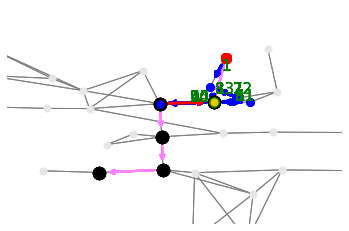

In [507]:
print("Test")
print(e.instructions[sampled])
plot_gif(test_traj[sampled], e, True, kidnapped_traj[sampled])